In [1]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 경고
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        # !apt-get update -qq
        # !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

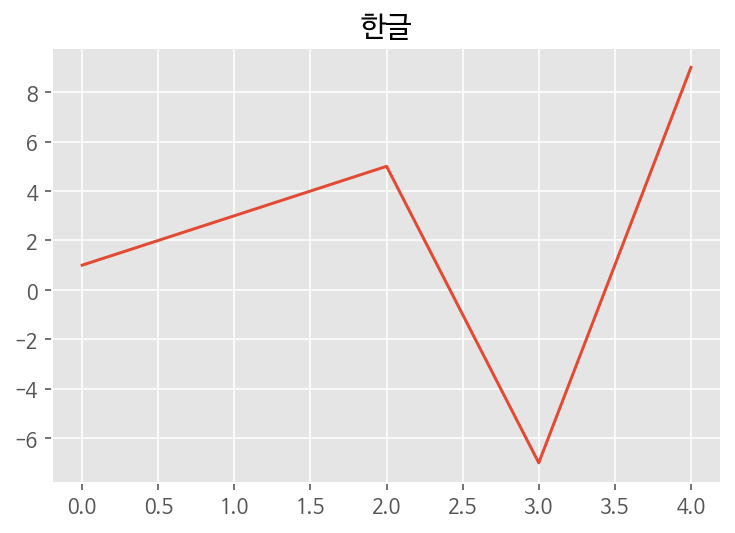

In [4]:
# 시각화를 위한 폰트설정
import matplotlib.pyplot as plt

# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당
font_family = get_font_family()

# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# 한글폰트 확인
pd.Series([1,3,5,-7,9]).plot(title="한글")

## 데이터 불러오기

In [5]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/물류 유통량 예측 경진대회/train.csv")
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/물류 유통량 예측 경진대회/test.csv')

submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/물류 유통량 예측 경진대회/sample_submission.csv")

In [6]:
print("train:", train.shape)
print('test:', test.shape)

train: (31684, 5)
test: (7920, 4)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         31684 non-null  int64 
 1   송하인_격자공간고유번호  31684 non-null  int64 
 2   수하인_격자공간고유번호  31684 non-null  int64 
 3   물품_카테고리       31684 non-null  object
 4   운송장_건수        31684 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         7920 non-null   int64 
 1   송하인_격자공간고유번호  7920 non-null   int64 
 2   수하인_격자공간고유번호  7920 non-null   int64 
 3   물품_카테고리       7920 non-null   object
dtypes: int64(3), object(1)
memory usage: 247.6+ KB


In [9]:
train.columns = ['index','송하인','수하인','물품','운송장']

## Train

In [10]:
train.head()

,index,송하인,수하인,물품,운송장
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [11]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

train['물품'].value_counts()

농산물              20321
문화컨텐츠             1091
음료                1034
수산                 860
가공식품               846
기타식품               698
건강식품               591
음반                 576
축산                 383
냉동/간편조리식품          375
과자                 320
생활용품               318
반려동물               315
주방용품               300
상의                 294
기타패션의류             236
기타디지털/가전           220
스킨케어               205
문구/사무용품            167
건강용품               162
아우터                155
하의                 150
기저귀/물티슈            130
기타화장품/미용           102
공구                  95
다이어트식품              92
의료용품                82
인테리어소품              72
신발                  70
취미용품                66
침구단품                58
언더웨어                56
이미용가전               51
주방가전                48
헤어케어                46
위생/건강용품             43
완구/매트               43
김치                  36
DIY자재/용품            36
주방가구                33
음향가전                33
클렌징                 32
계절가전                32
자동차용품      

In [12]:
train['송하인'].value_counts()

5011000078068400    3882
5013000610049100    1790
5013000731055200    1235
5011000137030100    1137
5013000821028200     731
                    ... 
4511300030055300       1
4719000321023400       1
4423000423020300       1
4711300748080100       1
2811000139076100       1
Name: 송하인, Length: 4229, dtype: int64

In [13]:
train['수하인'].value_counts()

5013000635005300    35
5011000543041100    33
5011000314069300    33
5011000544072300    30
5011000318044100    30
                    ..
5011000109040100     1
4183000550093100     1
4425000028078200     1
1147000011064300     1
5011000263065200     1
Name: 수하인, Length: 26875, dtype: int64

- 격자공간고유번호: 공간정보 표준화를 위해 고유로 부여한 격자공간 고유번호
- 격자공간명 
- 시군구코드 (1~5)
- 시군구명

> 5011000000 : 	제주특별자치도 제주시   
> 5013000000 :	제주특별자치도 서귀포시

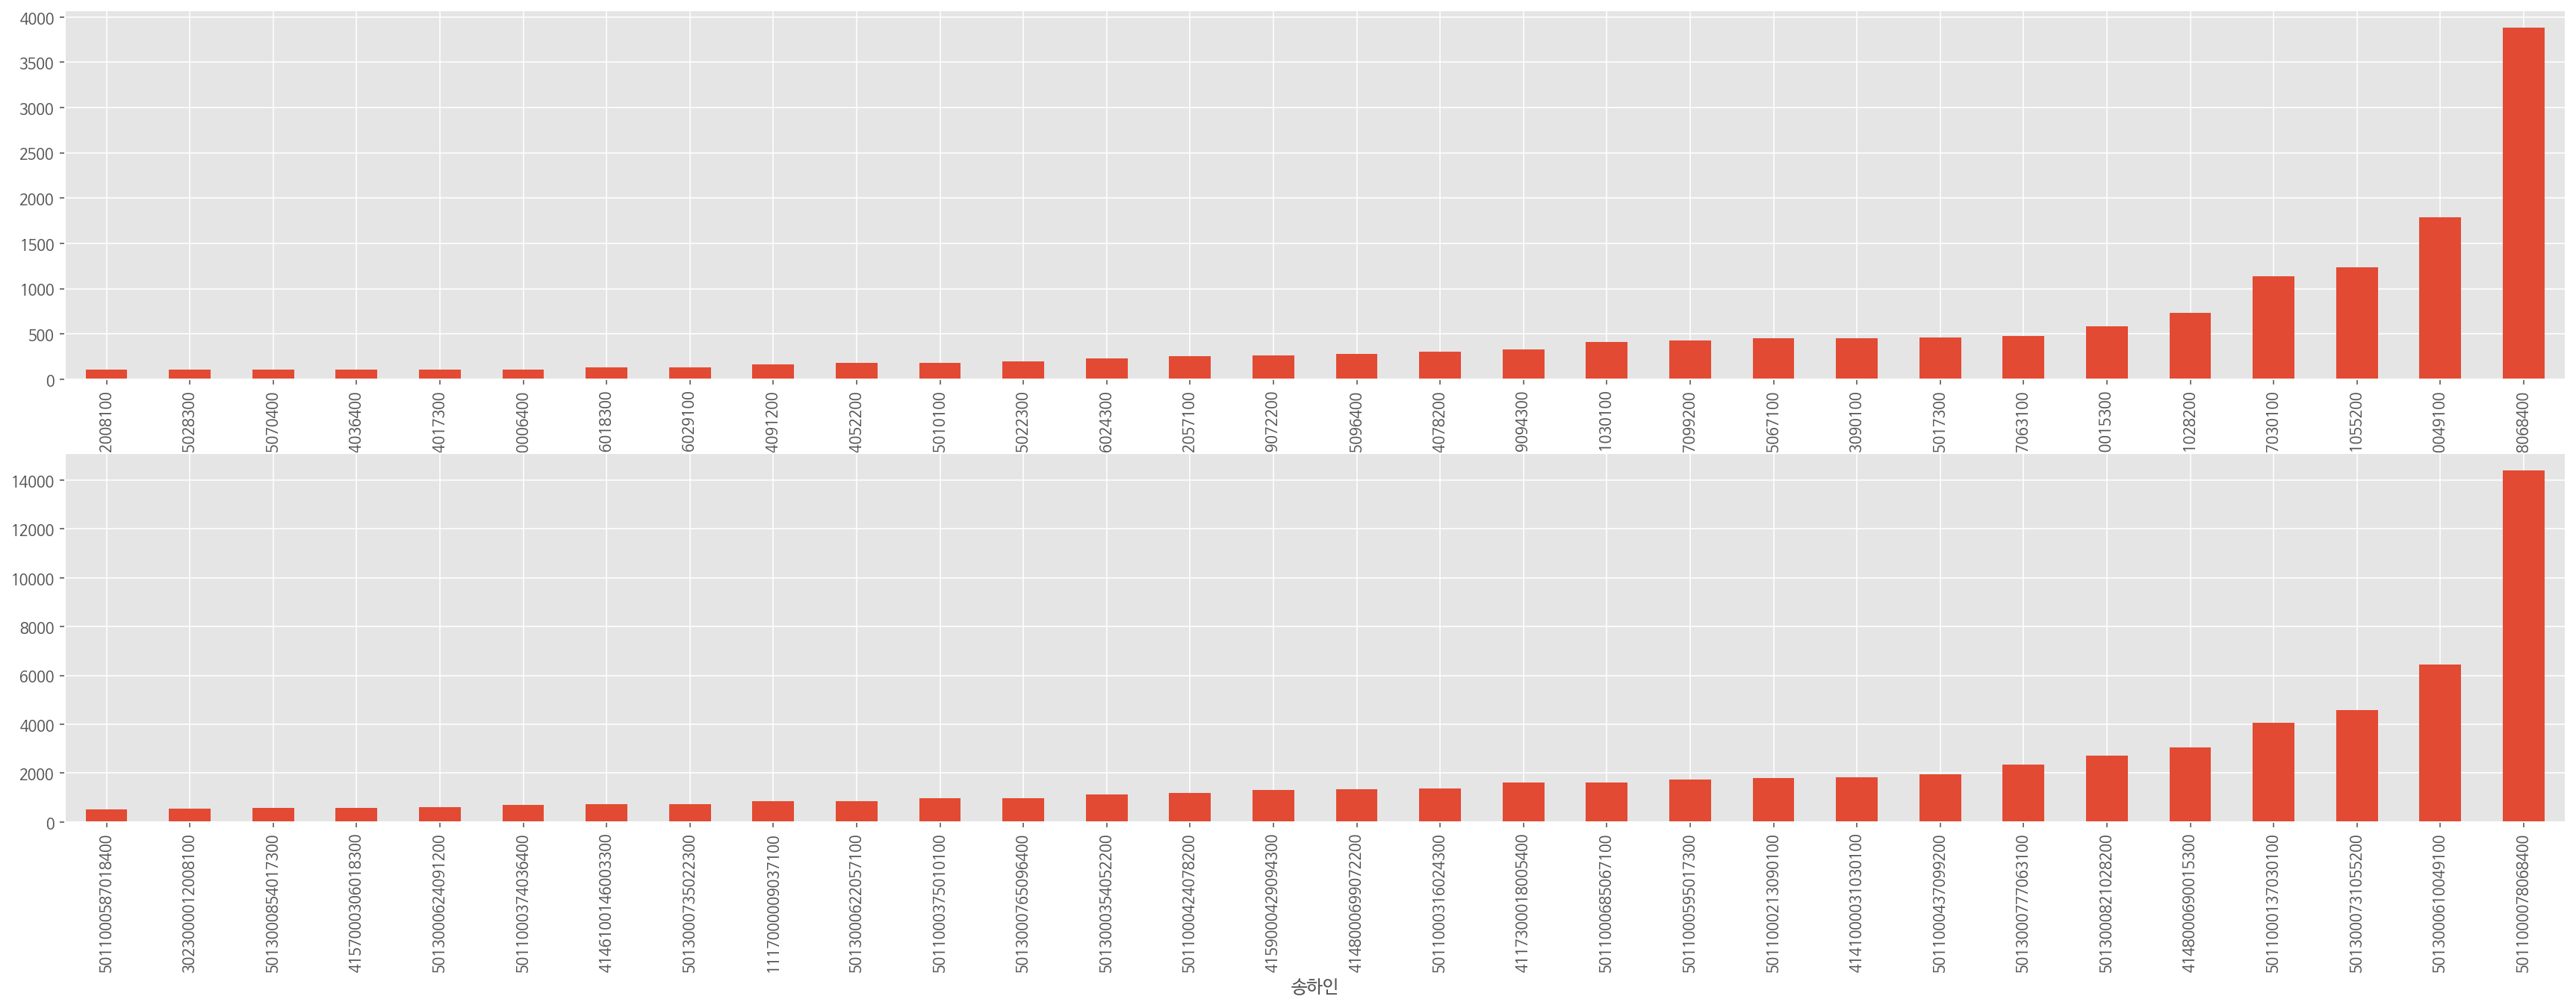

In [29]:
# 운송장 별 송하인
plt.subplot(2, 1, 1)
order_send = train.groupby('송하인').count()['운송장'].sort_values()
order_send_plot = order_send.tail(30).plot(kind='bar', figsize=(30, 10))

# 송하인 운송장 합계
plt.subplot(2, 1, 2)
order_send_total = train.groupby('송하인').sum()['운송장'].sort_values()
order_send_total_plot = order_send_total.tail(30).plot(kind='bar', figsize=(30, 10))

In [ ]:
# 격자공간고유번호에서 시군구코드만 추출
train['송하인'] = train['송하인'].apply(str)
train['수하인'] = train['수하인'].apply(str)

# slice the index numbers
train['송하인'] = train['송하인'].str.slice(0,5)
train['수하인'] = train['수하인'].str.slice(0,5)

In [ ]:
print(train['송하인'])
print(train['수하인'])

0        50110
1        41480
2        50110
3        41271
4        50110
         ...  
31679    44710
31680    11290
31681    11290
31682    41273
31683    28110
Name: 송하인, Length: 31684, dtype: object
0        28710
1        50110
2        11200
3        50110
4        28237
         ...  
31679    50110
31680    50110
31681    50110
31682    50110
31683    50110
Name: 수하인, Length: 31684, dtype: object


Text(0, 0.5, '총 주문 건 수')

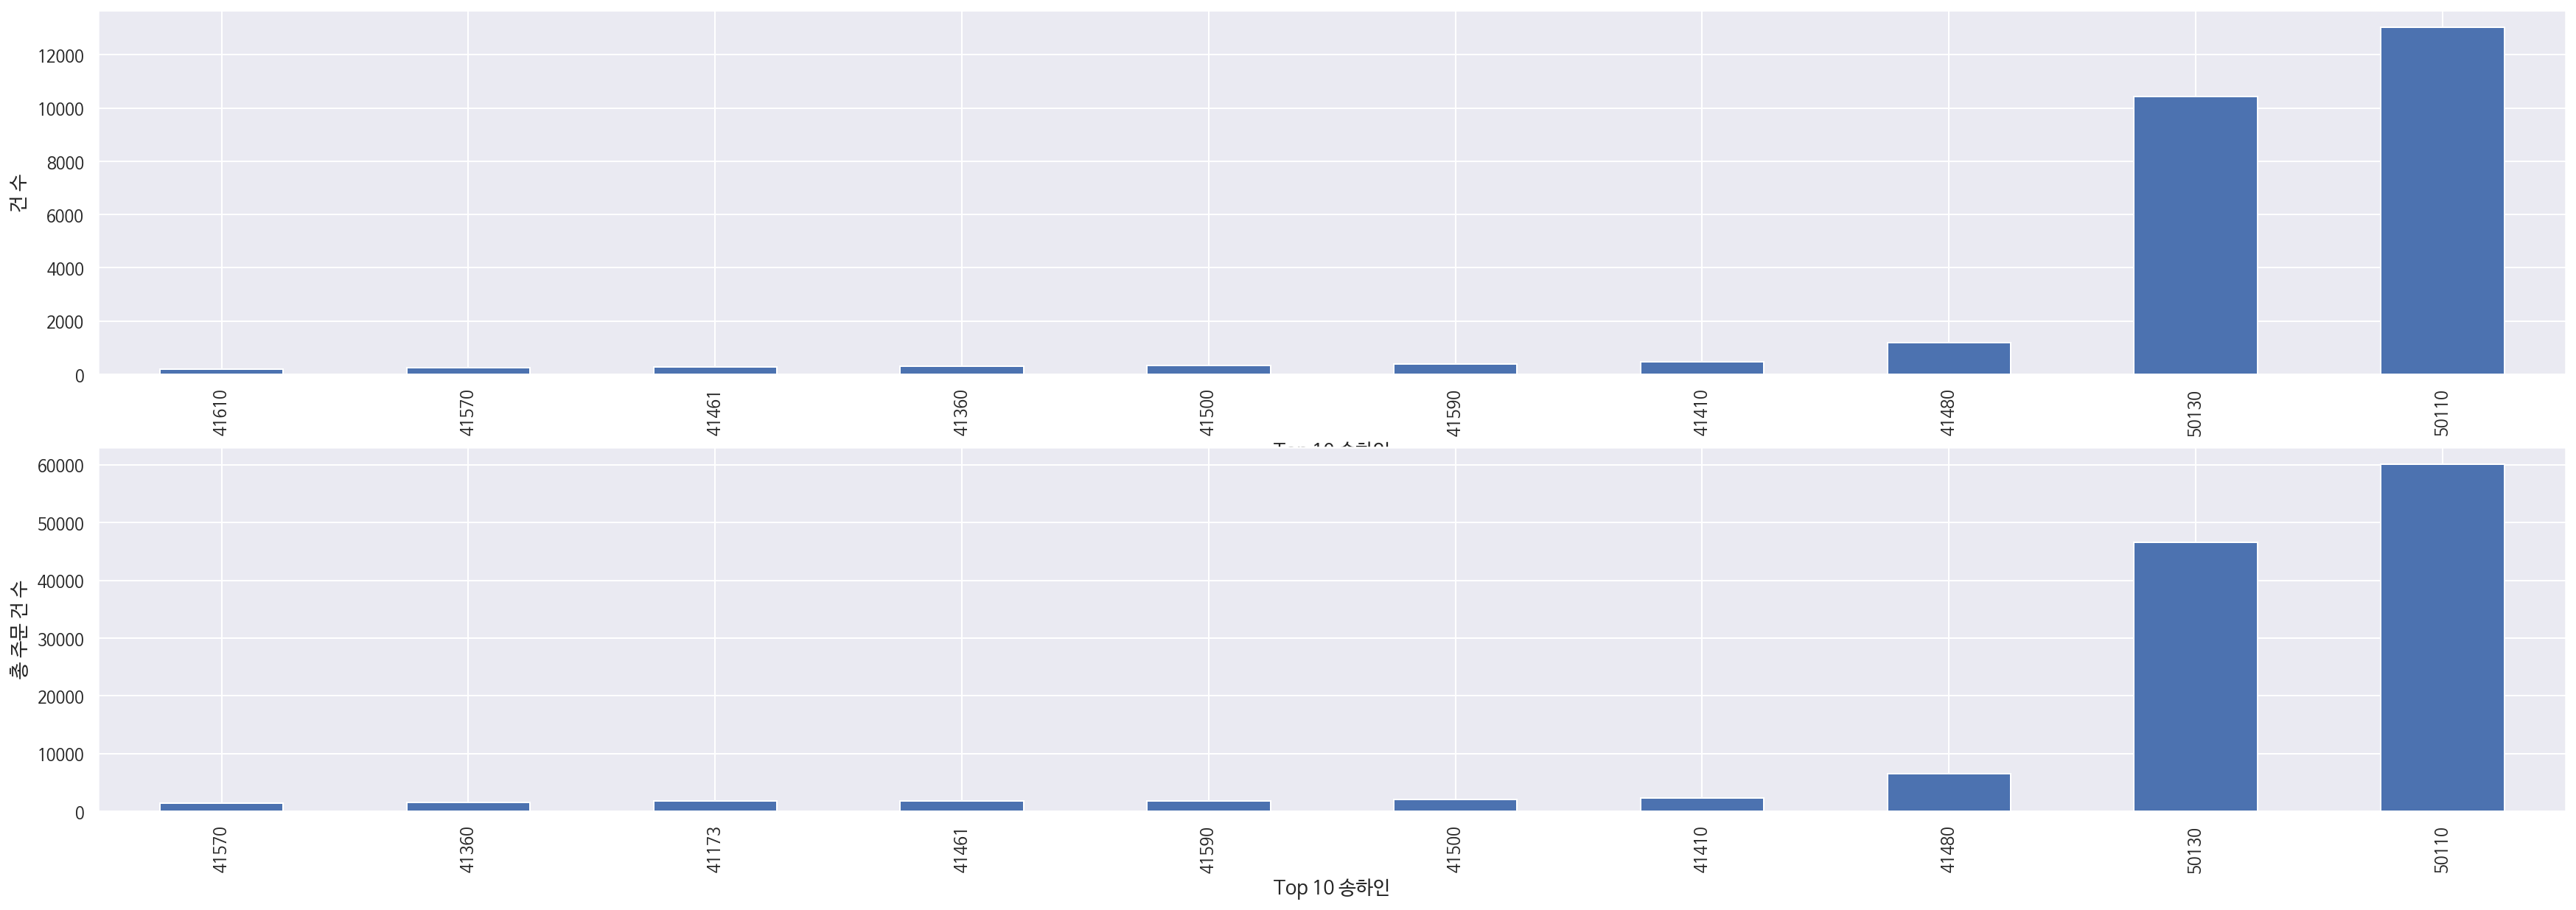

In [ ]:
# 운송장 별 송하인
plt.subplot(2, 1, 1)
order_send = train.groupby('송하인').count()['운송장'].sort_values()
order_send_plot = order_send.tail(10).plot(kind='bar', figsize=(30, 10))
order_send_plot.set_xlabel('Top 10 송하인', fontsize=13)
order_send_plot.set_ylabel('건 수', fontsize=13)

# 송하인 운송장 합계
plt.subplot(2, 1, 2)
order_send_total = train.groupby('송하인').sum()['운송장'].sort_values()
order_send_total_plot = order_send_total.tail(10).plot(kind='bar', figsize=(30, 10))
order_send_total_plot.set_xlabel('Top 10 송하인', fontsize=13)
order_send_total_plot.set_ylabel('총 주문 건 수', fontsize=13)

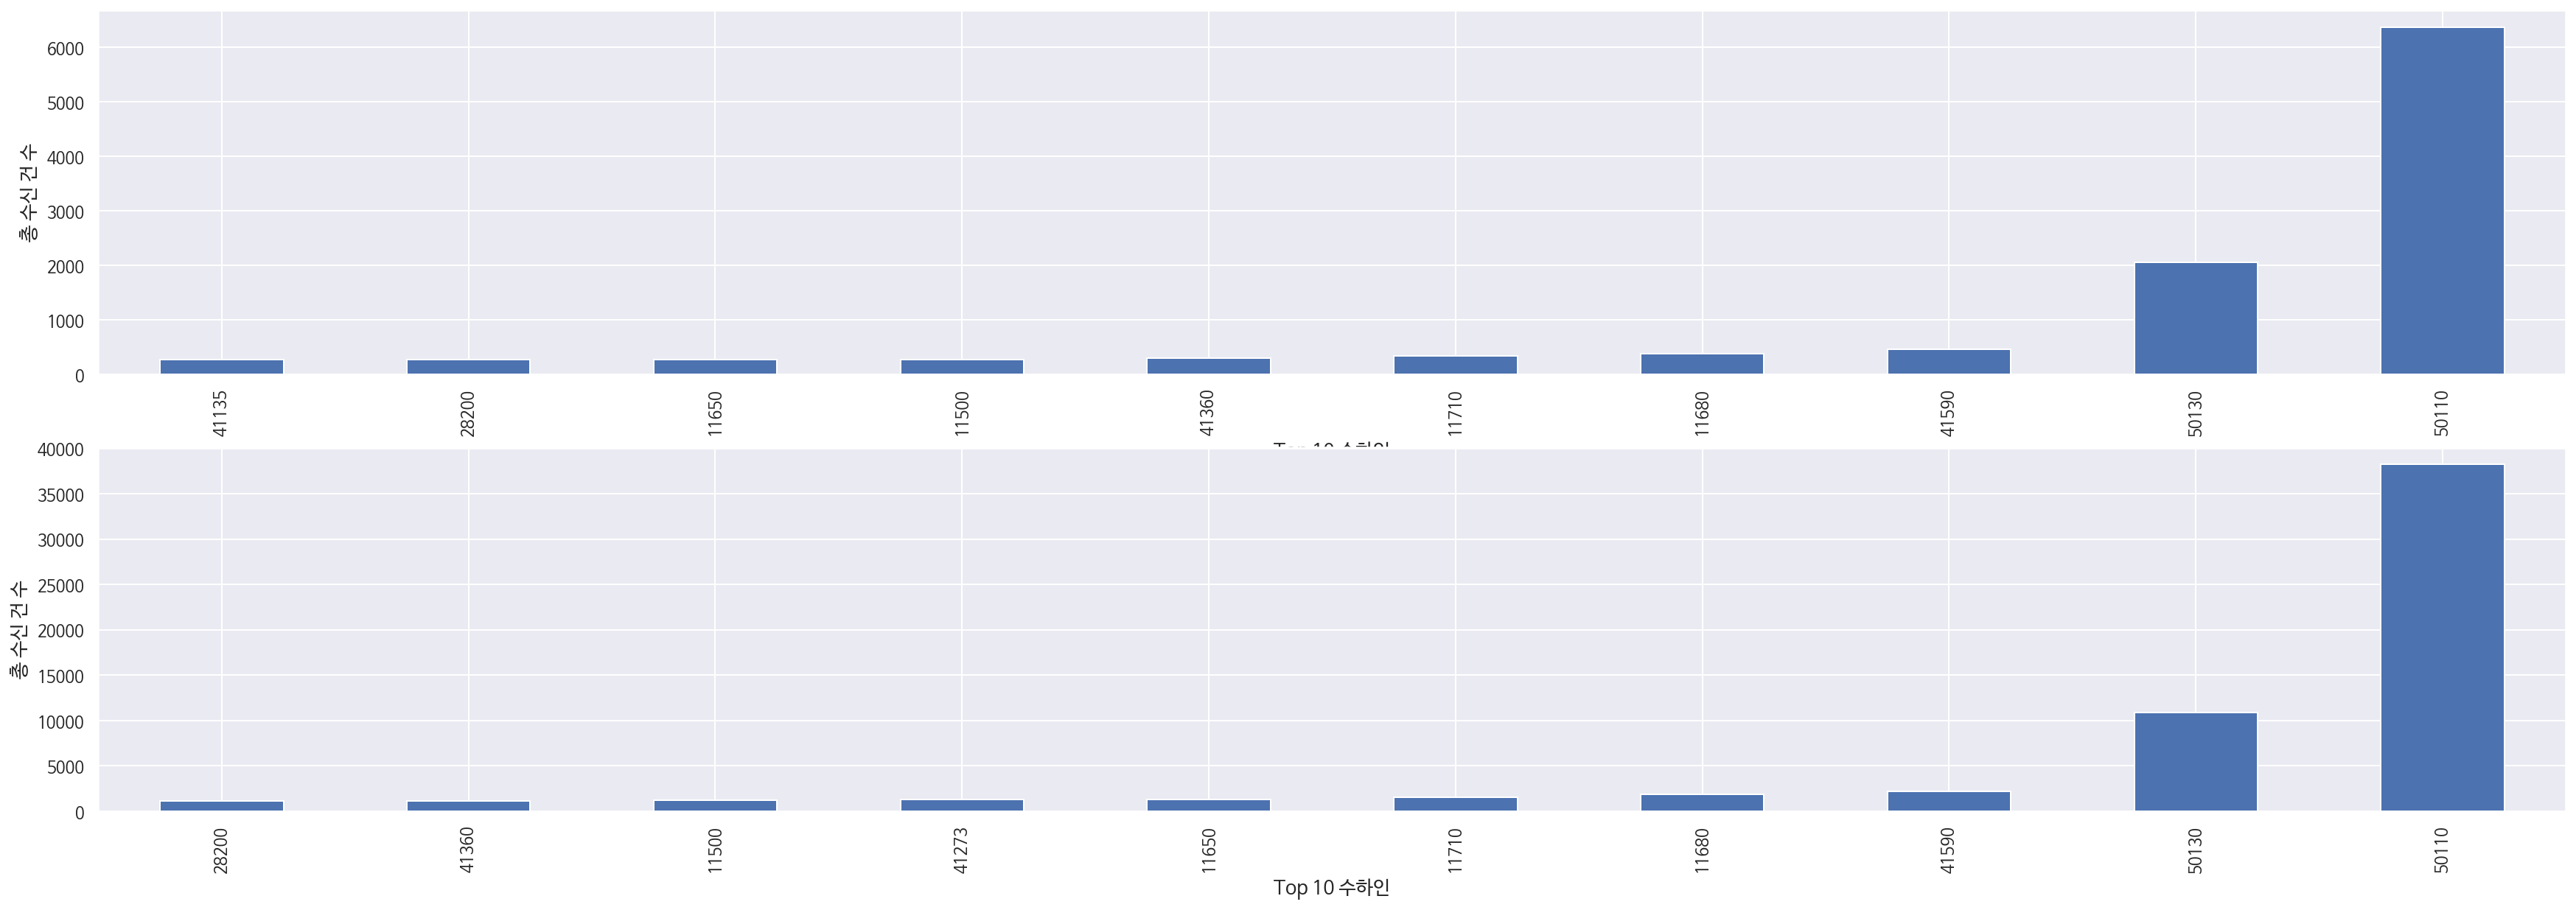

In [ ]:
# 운송장 별 수하인
plt.subplot(2, 1, 1)
order_recv = train.groupby('수하인').count()['운송장'].sort_values()
order_recv_plot = order_recv.tail(10).plot(kind='bar', figsize=(30, 10))
order_recv_plot.set_xlabel('Top 10 수하인', fontsize=13)
order_recv_plot.set_ylabel('총 수신 건 수', fontsize=13)

# 수하인 별 운송장
plt.subplot(2, 1, 2)
order_recv_total = train.groupby('수하인').sum()['운송장'].sort_values()
order_recv_total_plot = order_recv_total.tail(10).plot(kind='bar', figsize=(30, 10))
order_recv_total_plot.set_xlabel('Top 10 수하인', fontsize=13)
order_recv_total_plot.set_ylabel('총 수신 건 수', fontsize=13)

plt.show()

In [ ]:
print(order_send.tail(10))
print(order_send_total.tail(10))

송하인
41610      194
41570      250
41461      283
41360      310
41500      341
41590      394
41410      472
41480     1199
50130    10431
50110    13030
Name: 운송장, dtype: int64
송하인
41570     1419
41360     1514
41173     1745
41461     1748
41590     1826
41500     1992
41410     2256
41480     6470
50130    46515
50110    60067
Name: 운송장, dtype: int64


In [ ]:
print(order_recv.tail(10))
print(order_recv_total.tail(10))

수하인
41135     263
28200     265
11650     269
11500     273
41360     298
11710     340
11680     372
41590     461
50130    2055
50110    6361
Name: 운송장, dtype: int64
수하인
28200     1123
41360     1162
11500     1217
41273     1268
11650     1320
11710     1530
11680     1815
41590     2188
50130    10858
50110    38246
Name: 운송장, dtype: int64


In [30]:
catm_count = train.groupby('물품').count()['운송장'].sort_values(ascending=False)
catm_count_total = train.groupby('물품').sum()['운송장'].sort_values(ascending=False)

catm_count.rename('건 수', inplace=True)
catm_count_total.rename('총 합계', inplace=True)

cat_count = pd.concat([catm_count, catm_count_total], axis=1)
cat_count

,건 수,총 합계
물품,,
농산물,20321,87829.0
문화컨텐츠,1091,5429.0
음료,1034,5890.0
수산,860,4880.0
가공식품,846,5766.0
기타식품,698,4250.0
건강식품,591,3413.0
음반,576,2357.0
축산,383,3385.0


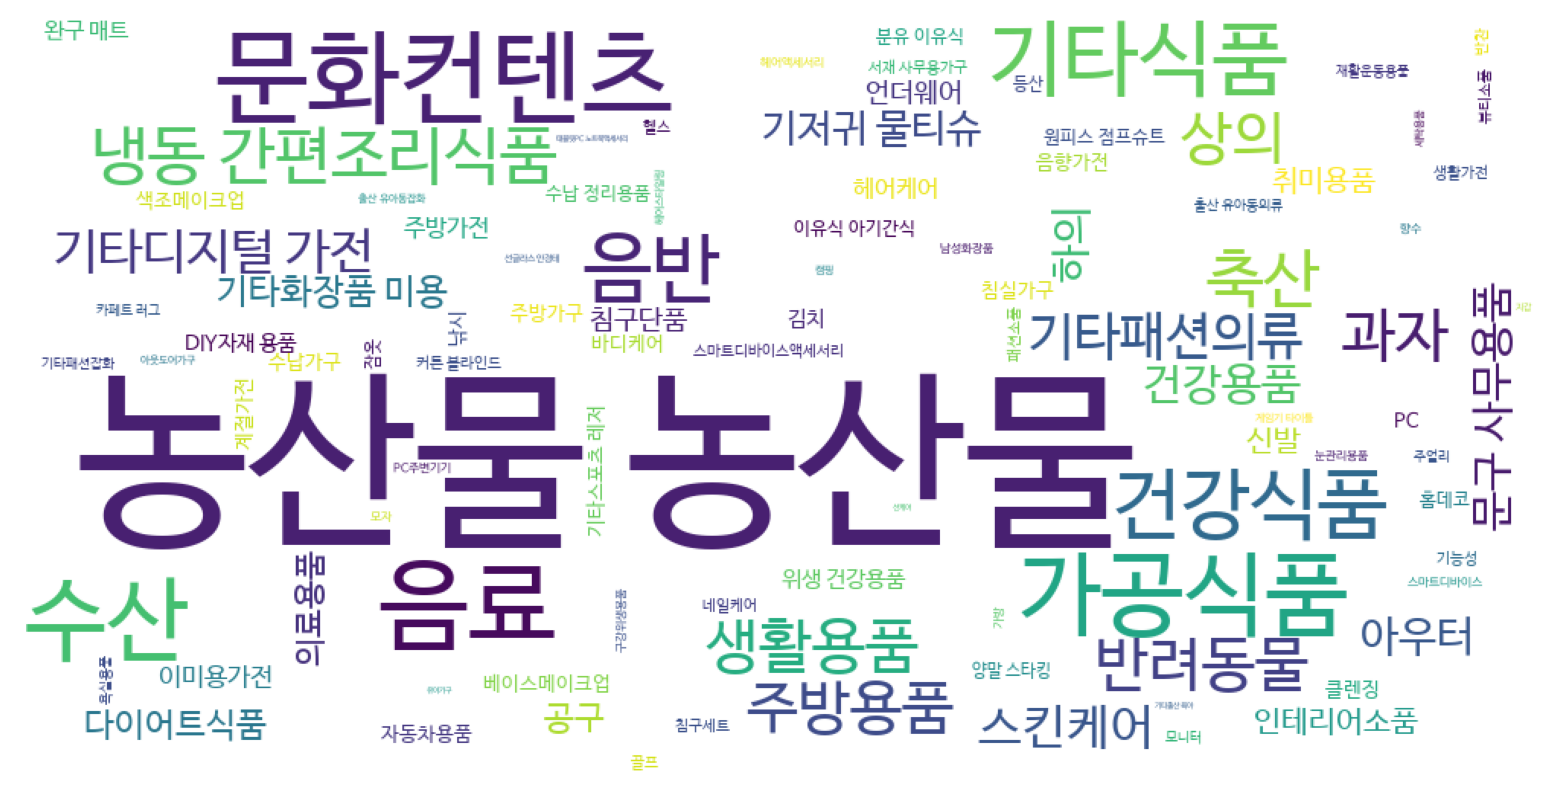

In [ ]:
from wordcloud import WordCloud 

text = " ".join(train['물품'])

def wordjoin(text, width=1000, height=500):
    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumBarunGothic.ttf",
        background_color="white",
        stopwords=['스포츠잡화'],
        width=width, height=height,
        random_state=42
    )

    word_draw.generate(text)

    plt.figure(figsize=(20,7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

wordjoin(text,width=1000, height=500)

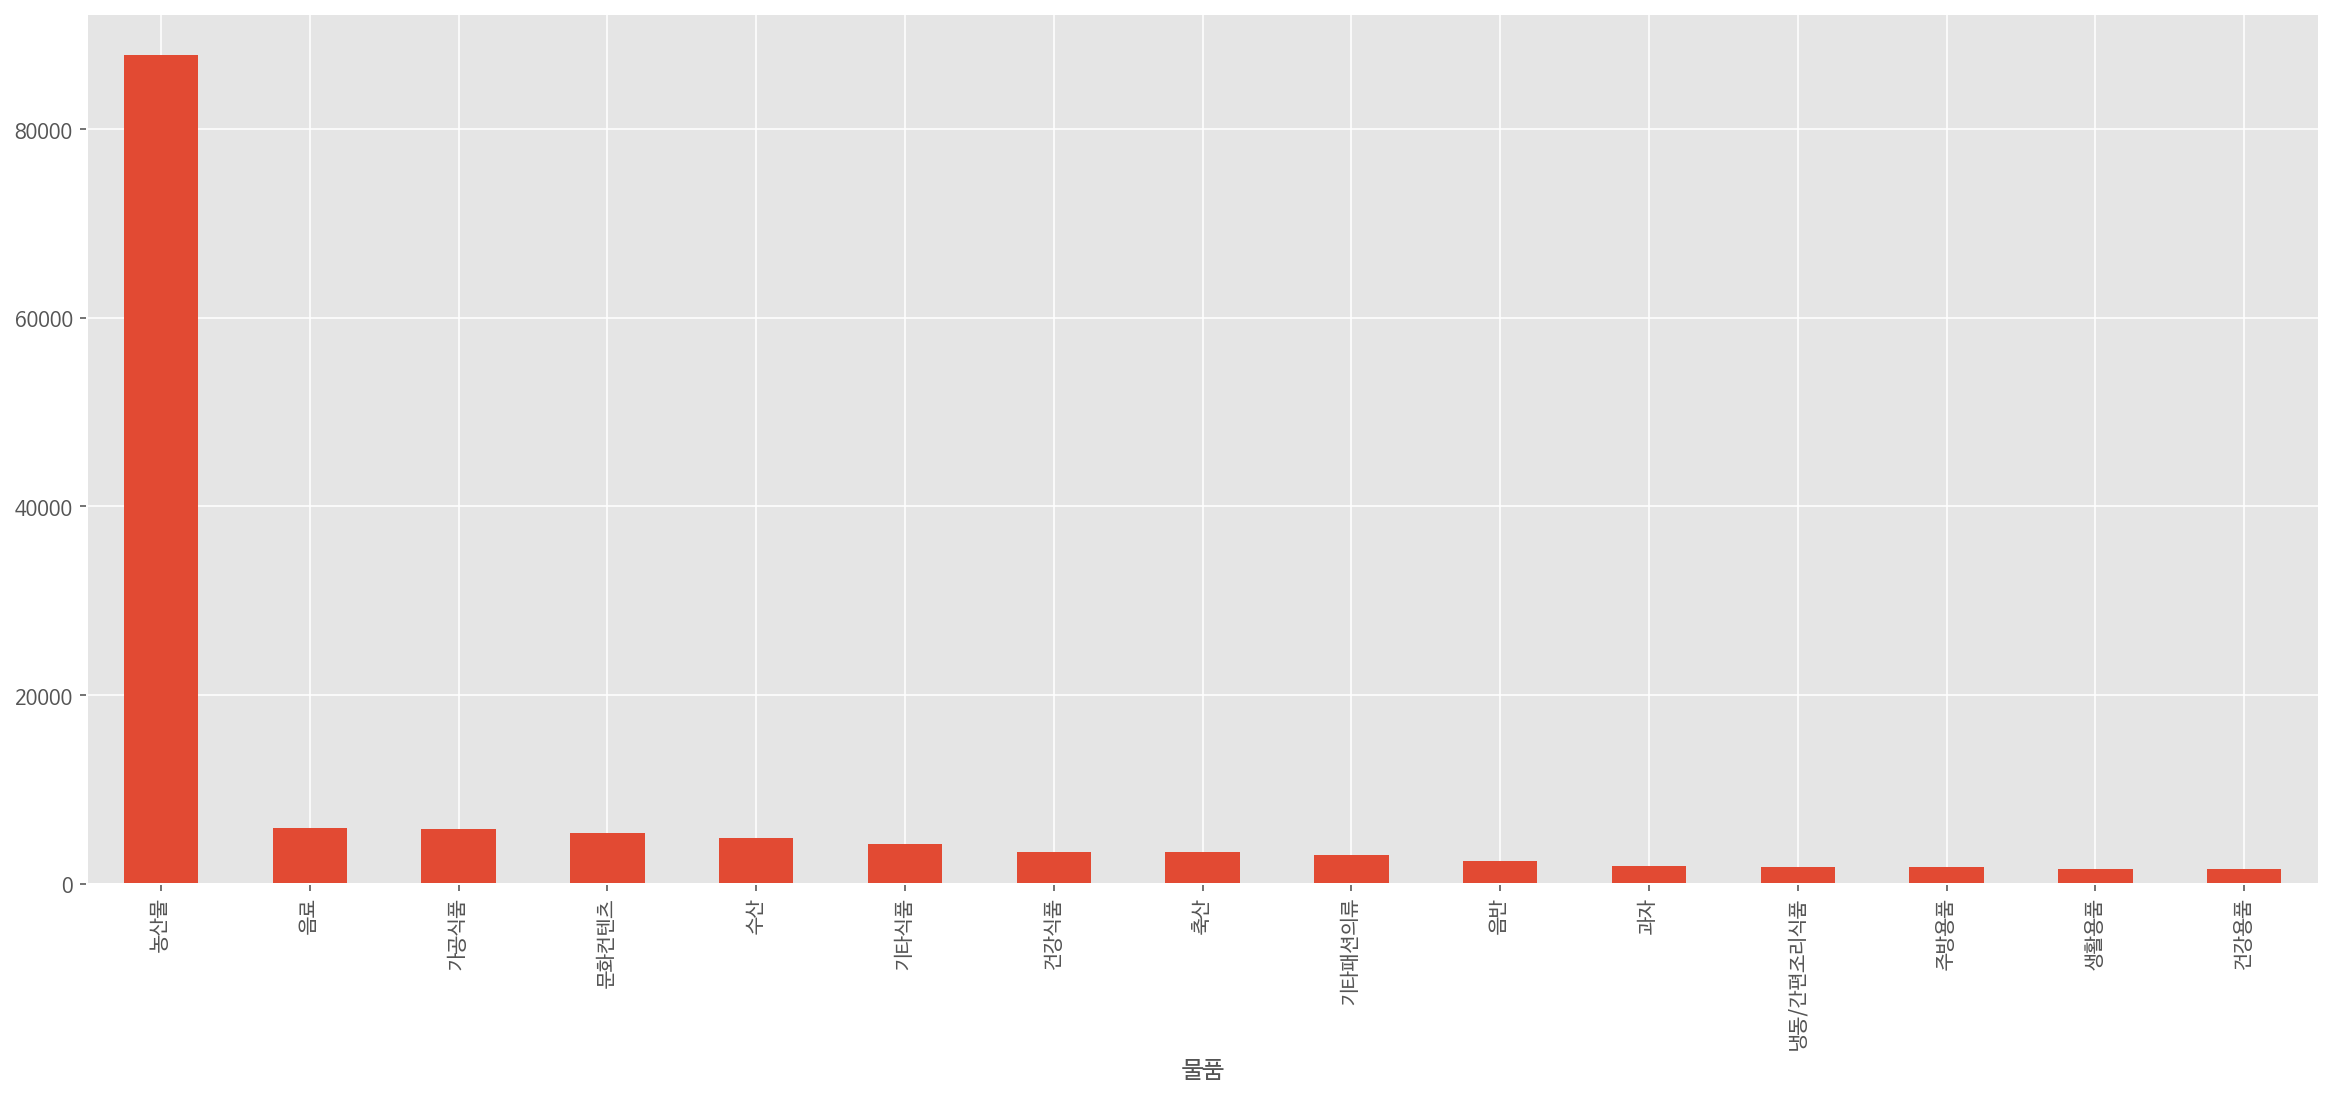

In [32]:
df = catm_count_total.head(15).plot.bar(figsize=(20, 8))

0         True
1         True
2        False
3         True
4        False
         ...  
31679     True
31680     True
31681     True
31682     True
31683     True
Name: 물품, Length: 31684, dtype: bool

## Test

In [ ]:
test.columns = ['index','송하인','수하인','물품']

In [ ]:
# 격자공간고유번호에서 시군구코드만 추출
test['송하인'] = test['송하인'].apply(str)
test['수하인'] = test['수하인'].apply(str)

# slice the index numbers
test['송하인'] = test['송하인'].str.slice(0,5)
test['수하인'] = test['수하인'].str.slice(0,5)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   7920 non-null   int64 
 1   송하인     7920 non-null   object
 2   수하인     7920 non-null   object
 3   물품      7920 non-null   object
dtypes: int64(1), object(3)
memory usage: 247.6+ KB


In [ ]:
test.describe(include='all')

,index,송하인,수하인,물품
count,7920.000000,7920,7920,7920
unique,NaN,196,250,100
top,NaN,50110,50110,농산물
freq,NaN,3176,1648,5080
mean,3959.500000,NaN,NaN,NaN
std,2286.451399,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1979.750000,NaN,NaN,NaN
50%,3959.500000,NaN,NaN,NaN
75%,5939.250000,NaN,NaN,NaN


In [ ]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["운송장"] - train["운송장"].mean()) <= (3*train["운송장"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(31684, 5)
(31337, 5)
